## Semester 1 Project Submission

Please fill out:
* Student name: Mason Batchelor, Jessica Pasqeusi, Maninder Bawa, Vijeet Yarlagadda
* Instructor name: Lera Tsayukova, Charlie Rice, Joe Comeaux

In [ ]:
# Your code here - remember to use markdown cells for comments as well!

In [1]:
### Relevant Imports ###
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import math
import os

%matplotlib inline

# Business Understanding

### Business Understanding

Computing Vision (a made-up company for the purposes of this project) sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t have much background in creating movies. You are charged with exploring what types of films are currently doing the best at the box office using different samples of available data. You then will translate those findings into actionable insights that the head of Computing Vision's new movie studio can use to help decide what type of films to create.

### What is Success?
We will define success in two ways. The first being the Gross Margin and the other being Total Profit. The Gross Margin calculations are detailed below. The reason we chose to focus on profitabilty metrics instead of ratings was because this company, computing vision, is trying to break into a well established market they want to ensure that the investment they put in is having a positive return. 

### Business Metrics

Our recommendations for this company will be based off of the Gross Margin which is portrayed as a percentage. The higher this percentage is the more the company is retaining for every dollar that is invested in the movie and as such is seeing a higher return on their investment. This is not necessarily equivalent to a standard ratio of Gross Margin which would include Net Sales and COGS however, considering the "Gross" columns of our data frame as a proxy for sales, and Production Budget as a proxy for COGS will yield similar results and actionable outcomes

$Gross Margin = \frac{Gross Revenue - Production Budget}{Gross Revenue} x 100$

This is an important metric, especially for a company about to enter an industry they have no presence in because it will help show how far their money goes to create profit. The higher this percentage the better the business will be doing because it is an indicator that retains more on each dollar of sales to its costs. This metric also allows us to take a standardized approach to comparing movies and their success. 

We want to investigate what a "Good Movie" i.e. a movie with a high Gross Margin is doing and try to emulate that. Thus we will explore the budget size, what directors are involved in those high margin films, and also what genres see the highest margin

# Data Understanding
### Opening all zipped files and databases

We began our exploring our data by unzipping the SQLite database as well as reading in all of out csv/tsv files into pandas data frames to get a better idea of how we can approach cleaning the data

In [ ]:
# open an sqlite connection

conn = sqlite3.connect("zippedData/im.db")
cur = conn.cursor()

In [ ]:
# Pull all of the tables in the database
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

In [ ]:
# query the notable tables movie_basics
q1 = """
SELECT *
FROM movie_basics
LIMIT 5;
"""
pd.read_sql(q1, conn)

In [ ]:
# query the notable tables movie_ratings
q2 = """
SELECT *
FROM movie_ratings
LIMIT 5;
"""
pd.read_sql(q2, conn)

### Database information

These two database tables share a "movie_id" column, thus we can join on this key and take a look at movie information including name, release year, and genre as well as the average rating with the number of votes. We want to find a good balance of average rating as well as number of ratings since a small number of really high ratings could skew the interpretation of what a "good" movie is.

### CSV and TSV file information

Read in all of the tsv and csv files in the proper formatting ensuring headers and proper indexing for the ones which require it as well as proper encoding for the tsv files

In [2]:
movie_info = pd.read_csv("zippedData/rt.movie_info.tsv",header = 0, sep = '\t')    

reviews = pd.read_csv("zippedData/rt.reviews.tsv", header = 0, sep = '\t', encoding= 'unicode_escape')

tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv", header = 0)    

movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", header = 0)

movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv", header = 0)

#### Movie Info Dataframe

This dataframe contains general information regarding the movies including rating, director, release date for theaters and DVD as well as the currency, box office, runtime and studio. There is a unique id column which we will not use as an index because it could be useful for combining data frames or doing different lookups

We may consider dropping currency, box office, and studio due to there being many missing values

Most columns are missing values and as such we will have to fill or deal with those missing values accordingly, this dataframe is related to the reviews data frame by the id column which relates to a unique id for each movie

In [ ]:
movie_info.info()

In [ ]:
movie_info.head()

#### Review Dataframe

The most important information from this dataframe will be the id which cooresponds to the movie that they are reviewing and the rating that they give it. We are missing about more than 10,000 ratings which is a considerable amount to discard, so we could fill these with the average value of the rating for the movie that they are reviewing. In order to make thge rating a useful variable we would have to apply a function to transform it from a string into a float rating value

A more advanced approach would be to conduct sentiment analysis and apply weights to the most common keywords found in a review at each score level and develop a heuristic to apply a score to the missing values based on the review that they left discarding all review entries without an actual review.

This data frame has a relation to the movie_info data frame since bothg come from rotten tomatoes. The id relates to the movie that each critic leaves a review for. 

In [ ]:
reviews.info()

In [ ]:
reviews.head()

In [ ]:
reviews['rating'].value_counts()

In [ ]:
reviews['rating'].value_counts()

#### The Movie DB Dataframe

This dataframe is not missing any values. It has information about genre ids and contains a unique id column along with the movie name, how many votes it received, and what the average vote value was. Vote seems to be this specific sites way of ranking the movies. 

In [ ]:
tmdb_movies.info()

In [ ]:
tmdb_movies.head()

In [ ]:
# Create a dictionary to relate the genre id's to the genre found on the movie DB website at 
# this customer support url: https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
tmbd_genres = {28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 80: "Crime", 99: "Documentary", 18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music", 9648: "Mystery", 10749: "Romance", 878: "Science Fiction", 10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"}

#### Movie Budgets Data Frame

This data frame is also not missing any values, it contains an ID for each movie, the title, production budget, how much the movie grossed domestically and how much it grossed worldwide

We will be transforming this data by making the budget and gross column integers as well as adding additional columns for profit and Gross Margin to help us in later analysis

In [ ]:
movie_budgets.info()

In [ ]:
movie_budgets.head()

#### Movie Gross Data Frame

This data frame is missing a lot of foreign gross values which could potentially be filled in by taking the difference from the budgets df ww_gross - domestic_gross, otherwise we will throw out those values because we can not estimate them.

An alternative that we will not explore is scraping the web with the name of the movie and pulling in the foreign gross numbers. We are missing a few domestic gross numbers which can be thrown away since there are not many of them or we can use the movie budgets dataframe again to fill those in. 

We most likely will not use this data frame because the movie_budgets dataframe offer the same information and a bit more that is helpful to our analysis

In [ ]:
movie_gross.info()

In [ ]:
movie_gross.head()

# Data Preparation

### Data Cleaning for movie_budgets DataFrame

The money_clean function we created removes the '$' and comma symbols from the input string. We used this function to clean the production_budget, domestic_gross, and worldwide_gross columns.

In [3]:
# This is the column of budgets which we want to investigate - notice formatting problems
prod_budget = movie_budgets["production_budget"]
prod_budget

0       $425,000,000
1       $410,600,000
2       $350,000,000
3       $330,600,000
4       $317,000,000
            ...     
5777          $7,000
5778          $6,000
5779          $5,000
5780          $1,400
5781          $1,100
Name: production_budget, Length: 5782, dtype: object

In [4]:
def money_clean(s):
    ''' 
    Takes in a string s, removes first character ($) and
    all commas return the value cast as an int
    '''
    s = s[1:]
    s = s.replace(",", "")
    return int(s)

# apply the method to the pandas series of budget values
prod_budget = prod_budget.apply(money_clean)

In [5]:
# Set this cleaned series to the budget column in the data frame
movie_budgets["production_budget"] = prod_budget

# apply the function to the other money columns
movie_budgets["domestic_gross"] = movie_budgets["domestic_gross"].apply(money_clean)
movie_budgets["worldwide_gross"] = movie_budgets["worldwide_gross"].apply(money_clean)

# Calculate new values for foreign gross 
movie_budgets["foreign_gross"] = movie_budgets["worldwide_gross"] - movie_budgets["domestic_gross"]

# calculate the profit by taking gross minus budget (Revenue - cost)
movie_budgets["domestic_profit"] = movie_budgets["domestic_gross"] - movie_budgets["production_budget"]
movie_budgets["foreign_profit"] = movie_budgets["foreign_gross"] - movie_budgets["production_budget"]
movie_budgets["total_profit"] = movie_budgets["worldwide_gross"] - movie_budgets["production_budget"]

In [6]:
# create new month and year columns for later analysis
rel_date = movie_budgets["release_date"].str.strip()

month = rel_date.apply(lambda x : x[:3])
year = rel_date.apply(lambda x : x[-4:])

movie_budgets["month"] = month
movie_budgets["year"] = year

In [7]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2015837654,335507625,1590837654,2351345279,Dec,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,804600000,-169536125,394000000,635063875,May,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,107000000,-307237650,-243000000,-200237650,Jun,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,944008095,128405868,613408095,1072413963,May,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,696540365,303181382,379540365,999721747,Dec,2017


# Exploratory Data Analysis and Visualization

## Mason Batchelor

##### Mason works only in this section and makes No changes to any other



### Analyzing Movie Budgets

Within the movie budgets data frame we created new column to represent the profit, month, and year for each of the entries. We are going to look at the relationship between many of these variables below. 

Adding in a Gross Margin column is essential given this is the metric we are most interested in. We will use this first to analyze the differnce in budgets, and recommend whether the company should target a large or small budget film. We are going to be taking a sample of 100 movies from the movie_budgets data frame to help with our analysis and visualizations. 

Additional Assumptions:
- only consider movies with a Gross value (worldwide, domestic, and foreign) greater than zero because you cannot calculate Gross Margin with 0 gross revenue
- random samples from this data frame are representative of the population, and will be used in a independent two sample ttest
- only consider within 1.5 times the IQR range on both sides to remove outliers
- Do this independently for each of the categories domestic, foreign, and worldwide to get more accurate results

##### Determine Budget Size Categories
Through research we found the following:
- Less than \\$5,000,000 is considered small budget
- Between \\$5,000,000 and \\$100,000,000 is considered medium budget
- greater than \$100,000,000 is considered big budget

##### Filter Gross Margins

Creating a Budget Size categorical variable to be used for visualizing the gross margins will be crucial. Below, we are working on creating mutliple visualizations for the gross margins for worldwide, domestic, and foreign. In order to properly ignore outliers we are ignoring  everything that is outside 1.5*IQR and this is because this company wants to know what will help them be most successful. By avoiding outliers at the top and bottom ends of the extremes we can more clearly see how most films perform

In [8]:
sns.set_style("darkgrid")

In [9]:
dates = pd.to_datetime(movie_budgets['release_date'])
months = dates.dt.month
movie_budgets['month_index'] = months

In [10]:
def budget_size(val): 
    ''' This function takes in a budget int value and returns a category'''
    if val < 5000000:
        return 1
    elif val < 100000000:
        return 2
    else:
        return 3

In [11]:
# Create the Gross Margin column in a new dataframe called budgets
budgets =  movie_budgets.copy(deep = True)

# only use movies that gross > 0 (denominator cannot be 0)
budgets = budgets.loc[budgets['worldwide_gross'] > 0]
budgets['budget_size'] = budgets['production_budget'].apply(budget_size)
# calculate gross Margin
budgets['gross_margin_ww'] = (budgets['worldwide_gross'] - 
budgets['production_budget']) / budgets['worldwide_gross'] * 100
# Create budget size categorical variable to analyze differences between them
# filtered_budgets.loc[:, 'budget_size'] = filtered_budgets.loc[:, 'production_budget'].apply(budget_size)

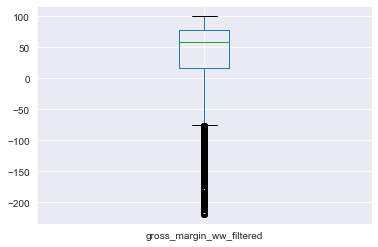

In [12]:
# REMOVE OUTLIERS from data frame
Q1 = budgets['gross_margin_ww'].quantile(.25)
Q3 = budgets['gross_margin_ww'].quantile(.75)
IQR = Q3 - Q1

# query out the outliers in the budgets data frame which are 1.5 x the iqr
statement = ((budgets['gross_margin_ww'] >= (Q1 - 1.5 * IQR)) & 
            (budgets['gross_margin_ww'] <= (Q3 + 1.5*IQR)))

filtered_budgets = budgets.loc[statement]
# Ploting the result to check the difference 
budgets.join(filtered_budgets, rsuffix='_filtered').boxplot(['gross_margin_ww_filtered']);

#### Recap
We have all of the movies gross margin, and have removed any outliers that may skew the data related to budget. We have a value of 1, 2, or 3 to each of the movies indicating whether or not they are small, medium, or big budget films. We can move on with our analysis now to look at relationships between gross margin and the rest of the factors

### Relationship Between Ratings and Financial Variables

Below we wanted to explore the relationship between ratings and movie production budgets, total profit, and worldwide gross marign. The findings were rather inconclusive as many data values are lost trying to relate the imdb database and the budgets dataframe due to a lack of common relation. We attempted to merge using the movie title however that did not offer nearly as many rows as we would have liked. 

The relationships can be described as follows:
- 

In [ ]:
q1 = """
SELECT *
FROM movie_basics
Limit 5;
"""
pd.read_sql(q1, conn)

In [ ]:
q2 = """
SELECT *
FROM movie_ratings
Limit 5;
"""
pd.read_sql(q2, conn)

In [ ]:
q3 = """
SELECT movie_id, primary_title as title, averagerating, numvotes 
FROM movie_basics as b
    JOIN movie_ratings as r
        USING (movie_id);
"""

df = pd.read_sql(q3, conn)

In [ ]:
df2 = filtered_budgets.merge(df, left_on='movie', right_on='title', how = 'inner')

In [ ]:
df2.head(1)

#### Production Budget and Average Rating

There is a weak but positive relationship between these two variables. This is indicative that a high budegt movie does not necessaryily yield high ratings and in fact some of the highest rated movies are on the lower end of the spectrum. This shows up that rating does not necessarily relate very strongly to a companies investment. 

In [ ]:
sns.regplot(data = df2, x = 'production_budget', y = 'averagerating')
df2[['production_budget', 'averagerating']].corr()

#### Total Profit and Average Rating

There is a weak, positive correlation between the average rating of a movie and the total profit. As the average rating goes up, we would expect a slight trend upward in the total profit however this relationship is not very strong and average rating does not seem to be the best metric for determining financial success which would be important to Computing Vision

In [ ]:
sns.regplot(data = df2, x = 'averagerating', y = 'total_profit')
df2[['total_profit', 'averagerating']].corr()

#### Gross Margin Worldwide and Average Rating

Our metric of Gross Margin compared to average rating shows a weak relationship with a wide spread of data that does not give measurable insights. We believe that average rating is not a good indicator of success and as such we will focus our efforts on financial metrics to determine what success is.

In [ ]:
sns.regplot(data = df2, x = 'gross_margin_ww', y = 'averagerating')
df2[['gross_margin_ww', 'averagerating']].corr()

#### Gross Margin Worldwide and Total Profit

As we can see, our metric is a stronger indicator of total profit than average rating. While it is not necessarily strong, it would seem that tjhis graph is exponential in nature and a different metric of comparison may be better suited. For us, the correlation coefficient of 0.36 was sufficient to continue our analyses

In [ ]:
sns.regplot(data=filtered_budgets, x='gross_margin_ww', y='total_profit')
filtered_budgets[['gross_margin_ww', 'total_profit']].corr()

#### Production Budget and Total Profit

We see there is a moderate borderline strong correlation. This is to be expected however, as we will see later the big budget movies have the highest average total profit however, they are also less likely to be profitable. Fewer big budget films actually turn a profit compared to small budget films. This is good insight to confirms our assumptions that a higher capital investment in a film wield yield a higher magnitude of profits. However, it gets more interesting when looking at the gross margin comparisons of budgets.

In [ ]:
sns.regplot(data=filtered_budgets, x='production_budget', y='total_profit')
filtered_budgets[['total_profit', 'production_budget']].corr()

### Worldwide Gross Margin Visualizations

While looking at the Worldwide gross margin we are looking to see which of the budget size categories would be best to enter into. Worldwide is the initial, holistic view we want to see and this would indicate to us which movie budget size is best suited for turning revenue into profits. 

Below we observe the following:
- Small and Big budget sizes have a higher average gross margin than medium budget
- The total profit follows the expected pattern of small being the lowest and big being the largest
- After a Hypothesis test we observe that at the 90% and 95% confidence levels the means are not statistically significantly different

Based on the results of this hypothesis test we would then want to advise the management of Computing Vision to target a small budget movie because there is not a statistically significant difference in the gross margin of small and large

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_budgets.groupby('budget_size')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)

# Format axis ticks and labels
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_title("Average Gross Margin for Worldwide by Budget Size", fontsize = 18)
plt.tight_layout();

# Save as a jpg file
strFile = "visuals/Mean_Gross_Margin_by_Budget_Size.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_profit = filtered_budgets.groupby('budget_size')['total_profit'].mean()

sns.barplot(x=x_values, y = agg_profit.values)
ax.set_ylabel("Average Total Profit (in $)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals])

ax.set_title("Average Total Profit for each budget size category", fontsize = 18)
plt.tight_layout();

### Hypothesis Testing

$H_0:$ There is no difference between small and big budget mean worldwide gross profit margin 

$H_A:$ The mean Worldwide gross profit margins are different for small and big budget film

We want to use statistical analysis rather than simply a graph because we want to conclude that the mean of both of these samples is the same. We did not analyze every movie to exist and as such we wanted to ensure that our information and the claims that we are making have a statistical backing.

This problem is suited for this analysis because we are observing two seperate groups - the small budget movies and the big budget movies. We are curious if there is a statistically significant difference between their average gross profit margins because we want to be able to make a recommendation to Computing Vision of how much to invest. As we saw above, gross margin correlates weak to moderately with total profit and thus we want to know if the gross margins are different for these two groups.

Limitations: given the information provided, we are not sure what the sample was, as all we know is that it came from the file provided. In addition, we made assumptions that only considered films with worldwide gross greater than zero (mathematical purposes) and removing outliers who were 1.5 times the IQR removed from the data. These could lead to skewed results. 

Recommendation and Findings: With the information provided below, the means from the two samples are not significantly different, the mean gross profit margin for small budget films is comparable to that of a big budget film. Something to note is that the scale of these are drastically different. However, for a company such as Computing Vision making their first break into the film industry, beginning with a low budget film that has the potential to turn a high percentage of gross revenue into profits can be a great start which they can then scale up and produce bigger budget films as they become a better known name in the industry

In [ ]:
budget_size_means = filtered_budgets.groupby('budget_size')['gross_margin_ww'].mean()
budget_size_stds = filtered_budgets.groupby('budget_size')['gross_margin_ww'].std()
budget_size_val_cnts = filtered_budgets.groupby('budget_size')['gross_margin_ww'].count()

mean1 = budget_size_means[1]
std1 = budget_size_stds[1]
nobs1 = budget_size_val_cnts[1]
mean2 = budget_size_means[3]
std2 = budget_size_stds[3]
nobs2 =  budget_size_val_cnts[3]

print(f'Small Budget Mean Gross Margin: {mean1:.4f}')
print(f'Big Budget Mean Gross Margin:   {mean2:.4f}\n')
# hyopothesis test for the mean gross margin of small and big budget films
results = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2)
print(f'''P Value: {results.pvalue} > .05 thus fail to reject the null hypothesis, 
            evidence does not support that the average gross margin is different for 
            the small and big budget films''')

### Observations of Outliers

We want to observe the outlier to get a better sence of what the data is showing that we are removing.

In [ ]:
Q1 = budgets['gross_margin_ww'].quantile(.25)
Q3 = budgets['gross_margin_ww'].quantile(.75)
IQR = Q3 - Q1

# query out the outliers in the budgets data frame which are 1.5 x the iqr
statement = ((budgets['gross_margin_ww'] < (Q1 - 1.5 * IQR)) | 
            (budgets['gross_margin_ww'] > (Q3 + 1.5*IQR)))

outliers = budgets.loc[statement]

In [ ]:
outliers['gross_margin_ww'].describe()['mean']

In [ ]:
outliers.head()

##### Recap
After observing that the mean of our outliers was so extreme, we thought that it was best to remove these values from the data frame using the standard convention of 1.5 times the IQR. This helped us to observe values that we could create actionable results off of without skewing the data in a way that would cause us to advise improperly. 

It is important to note the existence of these outliers and observe that they are potential examples of what could happen should Computing Vision enter the film industry. By choosing to avoid them, we want to focus on how Computing Vision can be most profitable by mimicing what the films in our sample do. 

### Domestic Gross Margin Visualizations

While looking at the Domestic gross margin we are looking to see which of the budget size categories would be best to enter into. With Domestic, we want to see if there is a specific emphasis between foreign and domestic that the company should have. In other words we want to explore whether they should focus their efforts on Domestic audiences or also Foreign. Our assumptions are the same as above. 

Below we observe the following:
- Small budgets have a higher average Gross Margin for domestic films than both medium and big
- Small budgets are the only positive average value which means on average medium and big budget films lose money domestically

From this we would also want to advise the firm to make a small budget film. Given that the Gross Margin, which represents the ability to convert theater sales into profit given their investment in the project aka their production budget. Having a negative ratio means that they are spending more than the gross revenue coming in which would not lead to a successful film. 

In [ ]:
# Create the Gross Margin column in a new dataframe called budgets
dom_copy =  budgets.copy(deep=True)
# only use movies that gross > 0 (denominator cannot be 0)
dom_copy = dom_copy.loc[dom_copy['domestic_gross'] > 0]
# calculate gross Margin
dom_copy['gross_margin_dom']= (dom_copy['domestic_gross'] - 
                              dom_copy['production_budget']) / dom_copy['domestic_gross'] * 100

# REMOVE OUTLIERS from data frame
Q1 = dom_copy['gross_margin_dom'].quantile(.25)
Q3 = dom_copy['gross_margin_dom'].quantile(.75)
IQR = Q3 - Q1
# filter out the outliers in the budgets data frame which are 1.5 x the iqr
# filtered_copy = copy.query('(@Q1 - 1.5 * @IQR) <= gross_margin_dom <= (@Q3 + 1.5 * @IQR)')

statement = ((dom_copy['gross_margin_dom'] >= (Q1 - 1.5 * IQR)) & 
            (dom_copy['gross_margin_dom'] <= (Q3 + 1.5*IQR)))
filtered_dom_copy = dom_copy.loc[statement]

# apply the budget size function to create a new column
# filtered_dom_copy.loc[:, 'budget_size'] = filtered_dom_copy.loc[:, 'production_budget'].apply(budget_size)

# Ploting the result to check the difference 
dom_copy.join(filtered_dom_copy, rsuffix='_filtered').boxplot(['gross_margin_dom_filtered']);

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_dom_copy.groupby('budget_size')['gross_margin_dom'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])

ax.set_title("Average Gross Margin for Domestic by budget size", fontsize = 18)
plt.tight_layout();

### Foreign Gross Margin Visualizations

While looking at the Foreign gross margin we are looking to see which of the budget size categories would be best to enter into. With Foreign, we want to see if there is a specific emphasis between foreign and domestic that the company should have. In other words we want to explore whether they should focus their efforts on Domestic audiences or also Foreign. Our assumptions are the same as above. 

Below we observe the following:
- Small budgets perform poorly to international audiences whereas big budgets see much greater success
- This is opposite of domestic, thus it will be essential to choose an area to focus on

From this our advise could sway. Big Budget films experience a far larger mean gross margin than small films in foreign markets. This is contrary to what we saw with the worldwide gross margin which makes us more skeptical of these results, the same goes for the domestic gross margin as there must be different outliers impacting both of these. Regardless, we can advise to make a small budget movie and focus on a domestic audience

In [ ]:
# Create the Gross Margin column in a new dataframe called budgets
for_copy =  budgets.copy(deep=True)
# only use movies that gross > 0 (denominator cannot be 0)
for_copy = for_copy.loc[for_copy['foreign_gross'] > 0]
# calculate gross Margin
for_copy['gross_margin_for']= (for_copy['foreign_gross'] - 
                              for_copy['production_budget']) / for_copy['foreign_gross'] * 100
# REMOVE OUTLIERS from data frame
Q1 = for_copy['gross_margin_for'].quantile(.25)
Q3 = for_copy['gross_margin_for'].quantile(.75)
IQR = Q3 - Q1
# query out the outliers in the budgets data frame which are 1.5 x the iqr
filtered_for_copy = for_copy.query('(@Q1 - 1.5 * @IQR) <= gross_margin_for <= (@Q3 + 1.5 * @IQR)')
# filtered_for_copy.loc[:, 'budget_size'] = filtered_for_copy.loc[:, 'production_budget'].apply(budget_size)

# Ploting the result to check the difference 
for_copy.join(filtered_for_copy, rsuffix='_filtered').boxplot(['gross_margin_for_filtered']);

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_for_copy.groupby('budget_size')['gross_margin_for'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])

ax.set_title("Average Gross Margin for Foreign by budget size category", fontsize = 18)
plt.tight_layout();

### Visualizing Random Samples

This was to assist us with our data exploration

In [ ]:
# take a random sample of size 100
sample_ww = filtered_budgets.sample(n=250) # .loc[budgets['gross_margin_ww'] > -100]
sample_dom = filtered_dom_copy.sample(n=250) # .loc[budgets_dom['gross_margin_dom'] > -100]
sample_for = filtered_for_copy.sample(n=250) # .loc[budgets_for['gross_margin_for'] > -100]

In [ ]:
# This plot is visualizing the WORLDWIDE profit margin calculated using worldwide gross
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,10), ncols = 2, nrows = 3)
sns.regplot(data = sample_ww, x = "gross_margin_ww" , y = "worldwide_gross", ax=ax[0,0]);
sns.regplot(data = sample_ww, x = "gross_margin_ww" , y = "production_budget", ax=ax[0,1]);

sns.regplot(data = sample_dom, x = "gross_margin_dom" , y = "domestic_gross", ax=ax[1,0]);
sns.regplot(data = sample_dom, x = "gross_margin_dom" , y = "production_budget", ax=ax[1,1]);

sns.regplot(data = sample_for, x = "gross_margin_for" , y = "foreign_gross", ax=ax[2,0]);
sns.regplot(data = sample_for, x = "gross_margin_for" , y = "production_budget", ax=ax[2,1]);

#ax1.set_title("Worldwide gross and profit margin (billion)")
#ax2.set_title("Production Budget and profit margin (hundred millions)")
plt.tight_layout();

In [ ]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,10), nrows=2)
sns.regplot(data = filtered_budgets, x = "gross_margin_ww" , y = "worldwide_gross", ax=ax[0]);
sns.regplot(data = filtered_budgets, x = "gross_margin_ww" , y = "production_budget", ax=ax[1]);

For high budget movies make sure to keep in mind the international audience because as the budget increases profits domestically trend downward however on the international audience profits trend upwards. If you are focusing on a low budget movie to enter into the movie industry then the focus should be domestic because profits tend to be higher comapred to international movies

In [ ]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample_ww, x = "production_budget" , y = "domestic_profit", ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample_ww, x = "production_budget" , y = "foreign_profit", ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample_ww, x = "production_budget" , y = "total_profit", ax=ax);

### Visualizing the Gross Margin Across Different Months

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = filtered_budgets.sort_values('month_index')['month'].unique()
agg_margin = filtered_budgets.groupby('month_index')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize = 16)
ax.set_title("Average Gross Margin by Month", fontsize = 24);
ax.set_xlabel("Month", fontsize = 20);

# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])


strFile = "visuals/Mean_Gross_Margin_by_Month.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = budgets.sort_values('month_index')['month'].unique()
agg_margin = budgets.groupby('month_index')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin")
ax.set_title("Average Gross Margin for each month");

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = movie_budgets.sort_values('month_index')['month'].unique()
agg_profit = movie_budgets.groupby('month_index')['total_profit'].mean()

sns.barplot(x=x_values, y = agg_profit.values)
ax.set_ylabel("Average Total Profit")
ax.set_title("Average Total Profit for each month");

#### Visualizing Total Profit Over Months

These graphs do not have aggregate values and are not being used in the current analysis

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,8), nrows = 2)
sns.barplot(data = sample_ww.sort_values('month_index'), 
            x = 'month', 
            y='total_profit', 
            ax = ax1, 
            errwidth=0)
sns.barplot(data = movie_budgets.sort_values('month_index'), 
            x = 'month', 
            y='total_profit', 
            ax=ax2, 
            errwidth=0)

ax1.set_title("250 sample movie most profitable months")
ax2.set_title("All movies most profitable months")
plt.tight_layout()

## Maninder Bawa

##### Maninder works only in this section and makes No changes to any other


## Jessica Pasquesi

##### Jessica works only in this section and makes No changes to any other


### Analyzing Movie Genres

Using the filtered movie budgets dataframe that contains Gross Margin columns, we are going to look at the different movie genres in comparison to gross margin and total profit. Gross Margin is the metric that we have been using as a measure of success. We are using this metric, along with total profit, to determine what genre has been most successful. By continuing using the filtered data from above, we are going off of the same assumtpions. To do analysis on the specific genres, we merged the filtered budget dataframe and the TMDB movies data frame that includes information on genres. 

Additional Assumption: 
* When looking at the genre data, we are given multiple genres in one column for a singular movie. We decided to make the assumption that the first genre in the list would be the primary genre and the genre that we will be using to categorize that movie. In this dataframe, there are a few empty values in the genre_ids column. When creating the new genre column, any empty value was named as "No Genre."

In [ ]:
budget_copy = filtered_budgets.copy()
tmdb_budget = pd.merge(tmdb_movies, budget_copy, left_on = 'title', right_on = 'movie')

In [ ]:
#tmdb_budgets = pd.merge(tmdb_movies, movie_budgets, left_on = 'title', right_on = 'movie')
#tmdb_budgets.sort_values(by='total_profit', ascending = False)

In [ ]:
# Cleaning up the genre_id column in tmbd_budget dataframe.
tmdb_budget['genre'] = None
index = 0
for row in tmdb_budget['genre_ids']:    
    row = row.strip()
    row = row.replace("[", "")        
    row = row.replace("]", "")
    row = row.replace(" ", "")
    row = row.split(",")
# Creating a new row, genre, to store the name of the first genre that we will be using as the main genre.
    for key in tmbd_genres.keys():
        if row[0] == "":
            tmdb_budget['genre'][index] = 'No Genre'
        elif int(row[0]) == key:
            tmdb_budget['genre'][index] = tmbd_genres[key]
    index+=1
                

To justify our assumption that the first genre is the primary genre, we decided to take a random sample of 10 movies from our dataframe and do research on each movie's specific genre.

In [ ]:
tmdb_budget.sample(n=10)

### Visualization of Number of Occurences of Each Genre

In [ ]:
tmdb_budget['genre'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budget['genre'].value_counts().index.tolist()
y_values = tmdb_budget['genre'].value_counts()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
print(tmdb_budget['genre'].value_counts())

From looking at the value counts, we see the Drama Movies are the most common movies in our dataframe. 

### World Wide Gross Margin Visualizations

In [ ]:
#genre vs average total profit
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budget['genre'].sort_values().unique()
y_values = tmdb_budget.sort_values('genre').groupby('genre')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_title("Mean Gross Margin by Genre", fontsize = 30)
ax.set_ylabel("Worldwide Gross Margin (in %)", fontsize = 20);
ax.set_xlabel("Genre", fontsize = 20);

# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
plt.xticks(rotation = 45)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])
plt.tight_layout()

# Save as a jpg file
strFile = "visuals/Mean_Gross_Margin_by_Genre.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

### Hypothesis Test 

Hypothesis test to see if the mean gross margin is a good indicator for which movie genre to choose


$H_0:$ There is no difference between Family genre and Mystery genre mean worldwide gross margin 

$H_A:$ The mean Worldwide gross profit margins are different for Family and Mystery Movies

We wanted to see whether we could recommend one genre to be better than the rest, and the results were that based off our samples we fail to reject the null hypothesis and therefore we cannot claim that the mean Gross Margin for Family movies is different than that of mystery movies

In [ ]:
genre_means = tmdb_budget.sort_values('genre').groupby('genre')['gross_margin_ww'].mean()
genre_stds = tmdb_budget.sort_values('genre').groupby('genre')['gross_margin_ww'].std()
genre_cnts = tmdb_budget.sort_values('genre').groupby('genre')['gross_margin_ww'].count()

In [ ]:
mean1 = genre_means['Family']
std1 = genre_stds['Family']
nobs1 = genre_cnts['Family']
mean2 = genre_means['Mystery']
std2 = genre_stds['Mystery']
nobs2 =  genre_cnts['Mystery']


print(f'Family Genre Mean Gross Margin: {mean1:.4f}')
print(f'Mystery Genre Mean Gross Margin:   {mean2:.4f}\n')
# hyopothesis test for the mean gross margin of Drama and Mystery
results = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2)
print(f'''P Value: {results.pvalue} > .05 thus fail to reject the null hypothesis, 
            evidence does not support that the average gross margin is different for 
            the small and big budget films''')
print('\n')
mean3 = genre_means['TV Movie']
std3 = genre_stds['TV Movie']
nobs3 =  genre_cnts['TV Movie']

print(f'Family Genre Mean Gross Margin: {mean1:.4f}')
print(f'TV Movie Genre Mean Gross Margin:   {mean3:.4f}\n')
# hyopothesis test for the mean gross margin of Drama and Mystery
results = stats.ttest_ind_from_stats(mean1, std1, nobs1, mean3, std3, nobs3)
print(f'''P Value: {results.pvalue} > .05 thus fail to reject the null hypothesis, 
            evidence does not support that the average gross margin is different for 
            the small and big budget films''')

### Gross Domestic Margin Visualization

To analyze the domestic gross margin, we are using the filtered dataframe with the column including domestic gross margin. We are repeating the same process of merging this dataframe with the TMDB movies dataframe that includes genre and creating a new column with the primary genre. 

In [ ]:
dom_budget_copy = filtered_dom_copy.copy()
tmdb_dom_budget = pd.merge(tmdb_movies, dom_budget_copy, left_on = 'title', right_on = 'movie')

In [ ]:
# Cleaning up the genre_id column in tmbd_dom_budget dataframe.
tmdb_dom_budget['genre'] = None
index = 0
for row in tmdb_dom_budget['genre_ids']:    
    row = row.strip()
    row = row.replace("[", "")        
    row = row.replace("]", "")
    row = row.replace(" ", "")
    row = row.split(",")
# Creating a new row, genre, to store the name of the first genre that we will be using as the main genre.
    for key in tmbd_genres.keys():
        if row[0] == "":
            tmdb_dom_budget['genre'][index] = 'No Genre'
        elif int(row[0]) == key:
            tmdb_dom_budget['genre'][index] = tmbd_genres[key]
    index+=1            

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_dom_budget['genre'].unique()
y_values = tmdb_dom_budget.groupby('genre')['gross_margin_dom'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Domestic Gross Margin");

### Gross Foreign Margin Visualization

To analyze the foreign gross margin, we are using the filtered dataframe with the column including foreign gross margin. We are repeating the same process of merging this dataframe with the TMDB movies dataframe that includes genre and creating a new column with the primary genre. 

In [ ]:
for_budget_copy = filtered_for_copy.copy()
tmdb_for_budget = pd.merge(tmdb_movies, for_budget_copy, left_on = 'title', right_on = 'movie')

In [ ]:
# Cleaning up the genre_id column in tmbd_for_budget dataframe.
tmdb_for_budget['genre'] = None
index = 0
for row in tmdb_for_budget['genre_ids']:    
    row = row.strip()
    row = row.replace("[", "")        
    row = row.replace("]", "")
    row = row.replace(" ", "")
    row = row.split(",")
# Creating a new row, genre, to store the name of the first genre that we will be using as the main genre.
    for key in tmbd_genres.keys():
        if row[0] == "":
            tmdb_for_budget['genre'][index] = 'No Genre'
        elif int(row[0]) == key:
            tmdb_for_budget['genre'][index] = tmbd_genres[key]
    index+=1            

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_for_budget['genre'].unique()
y_values = tmdb_for_budget.groupby('genre')['gross_margin_for'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Foreign Gross Margin");

## Analyzing Movie Genres with Profit

After looking at genres with gross margin, we noticed that it did not give very clear results. We decided to also analyze genres with profit. 

### Total Profit Visualizations


In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budget['genre'].sort_values().unique()
y_values = tmdb_budget.sort_values('genre').groupby('genre')['total_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_title("Mean Total Profit by Genre", fontsize = 30)
ax.set_ylabel("Total Profit", fontsize = 20);
ax.set_xlabel("Genre", fontsize = 20);
# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
plt.xticks(rotation = 45)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals])
plt.tight_layout()

# Save as a jpg file
strFile = "visuals/Mean_Total_Profit_by_Genre.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

### Domestic Profit Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budget['genre'].sort_values().unique()
y_values = tmdb_budget.sort_values('genre').groupby('genre')['domestic_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_title("Mean Domestic Profit by Genre", fontsize = 30)
ax.set_ylabel("Domestic Profit", fontsize = 20);
ax.set_xlabel("Genre", fontsize = 20);

# format axis ticks 
ax.xaxis.set_tick_params(labelsize=14)
plt.xticks(rotation = 45)
ax.yaxis.set_tick_params(labelsize=14)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals])
plt.tight_layout()

# Save as a jpg file
strFile = "visuals/Mean_Domestic_Profit_by_Genre.png"
if os.path.isfile(strFile):
   os.remove(strFile)
plt.savefig(strFile)

### Foregin Profit Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_for_budget['genre'].unique()
y_values = tmdb_for_budget.groupby('genre')['foreign_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Foreign Profit");

After looking at the different gross margins and total profits in relation to genre, we concluded the producing a genre movie would be the most successful. Genre movies are the most common movie being produced. When looking at 

## Vijeet Yarlagadda

##### Vijeet works only in this section and makes No changes to any other


In [26]:
genre_df = movie_budgets

genre_df["original_title"] = genre_df["movie"]

genre_df = pd.merge(genre_df, tmdb_movies, on=['original_title'])

budgets["return_on_investment"] = (budgets["total_profit"] / budgets["production_budget"]) * 100

### Probability of Profit

Probability of Profit is a metric used in the financial world to analyze investment risk. The formula to calculate POP is as follows:

$n$ = total number of events

$p_n$ = total number of profitable events

Probability of Profit = $\frac{p_n}{n}$

This can help inform us on how risky making any budget of movie is.


Percentage of Profit for small budget films:   52.04%% 
medium budget films:   65.06%% 
and big budget films:   79.80%%


C:\Users\viyarlagadda\AppData\Local\Temp\ipykernel_26572\1120458588.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])


Text(0.5, 1.0, 'Percentage of profiting films by budget size')

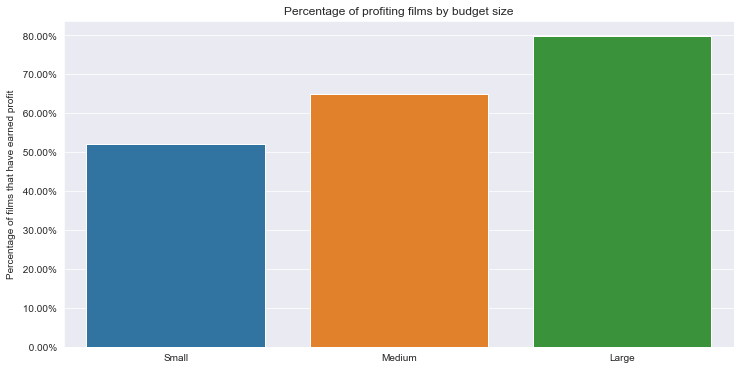

In [27]:
# Probability of Profit

pop_small = (len(movie_budgets[(movie_budgets["total_profit"] > 0) & (movie_budgets["production_budget"] < 10000000)]) / len(movie_budgets[movie_budgets["production_budget"] < 10000000])) * 100

pop_md = (len(movie_budgets[(movie_budgets["total_profit"] > 0) & (movie_budgets["production_budget"] > 10000000) & (movie_budgets["production_budget"] < 50000000)]) / len(movie_budgets[(movie_budgets["production_budget"] > 10000000) & (movie_budgets["production_budget"] < 50000000)])) * 100

pop_big = (len(movie_budgets[(movie_budgets["total_profit"] > 0) & (movie_budgets["production_budget"] >= 50000000)]) / len(movie_budgets[(movie_budgets["production_budget"] >= 50000000)])) * 100

print("Percentage of Profit for small budget films: ", f'{pop_small : .2f}%' + "%", "\nmedium budget films: ", f'{pop_md : .2f}%' + "%","\nand big budget films: ", f'{pop_big : .2f}%' + "%" )

fig, ax = plt.subplots(figsize=(12,6))
x_values = ["Small", "Medium", "Large"]

agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()
ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])

sns.barplot(x=x_values, y = [pop_small, pop_md, pop_big], errwidth=0)
ax.set_ylabel("Percentage of films that have earned profit")
ax.set_title("Percentage of profiting films by budget size")

#### This graph shows that more large films are profitable than small or medium films.

Next, we'll split the dataset into different datasets within their respective categories.

In [28]:
small_budget = budgets[budgets["production_budget"] < 10000000]
md_budget = budgets[(budgets["production_budget"] > 10000000) & (budgets["production_budget"] < 50000000)]
big_budget = budgets[(budgets["production_budget"] >= 50000000)]

In [29]:
def budget_size(val):
    if val < 10000000:
        return 1
    elif val < 50000000:
        return 2
    else:
        return 3
budgets["budget_size"] = budgets["production_budget"].apply(budget_size)

### Return on Investment

Return on Investment is a metric used to find out how profitable a particular financial transaction was.

The formula for ROI is as follows:

ROI = $\frac{Net Profit}{Cost of Investment}$

In [30]:
budgets.groupby("budget_size")["return_on_investment"].mean()

budget_size
1    894.372901
2    193.821873
3    176.662384
Name: return_on_investment, dtype: float64

In [31]:
budgets['gross_margin_dom'] = (budgets['domestic_gross'] - 
                              budgets['production_budget']) / budgets['domestic_gross'] * 100

budgets_dom = budgets.loc[budgets["domestic_gross"] > 0]

budgets_dom.groupby("budget_size")["gross_margin_dom"].mean()

budget_size
1   -4139.218258
2   -5871.489589
3    -600.921159
Name: gross_margin_dom, dtype: float64

In [32]:
budgets_dom.tail()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year,month_index,budget_size,gross_margin_ww,return_on_investment,gross_margin_dom
5775,76,"May 26, 2006",Cavite,7000,70071,71644,1573,63071,-5427,64644,May,2006,5,1,90.229468,923.485714,90.010133
5776,77,"Dec 31, 2004",The Mongol King,7000,900,900,0,-6100,-7000,-6100,Dec,2004,12,1,-677.777778,-87.142857,-677.777778
5778,79,"Apr 2, 1999",Following,6000,48482,240495,192013,42482,186013,234495,Apr,1999,4,1,97.505146,3908.250000,87.624273
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,0,-3662,-5000,-3662,Jul,2005,7,1,-273.692078,-73.240000,-273.692078
5781,82,"Aug 5, 2005",My Date With Drew,1100,181041,181041,0,179941,-1100,179941,Aug,2005,8,1,99.392403,16358.272727,99.392403


In [33]:
budgets['gross_margin_foreign'] = (budgets['foreign_gross'] - 
                              budgets['production_budget']) / budgets['foreign_gross'] * 100

budgets_foreign = budgets.loc[budgets["foreign_gross"] > 0]
budgets_foreign[budgets["gross_margin_foreign"] > -200].groupby("budget_size")["gross_margin_foreign"].mean()


C:\Users\viyarlagadda\AppData\Local\Temp\ipykernel_26572\2657383785.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  budgets_foreign[budgets["gross_margin_foreign"] > -200].groupby("budget_size")["gross_margin_foreign"].mean()


budget_size
1    30.144524
2     6.300749
3    13.340285
Name: gross_margin_foreign, dtype: float64

### Grouping by budget size to see them compared by various metrics

Text(0.5, 1.0, 'Mean total profit by budget size (USD, hundreds of millions)')

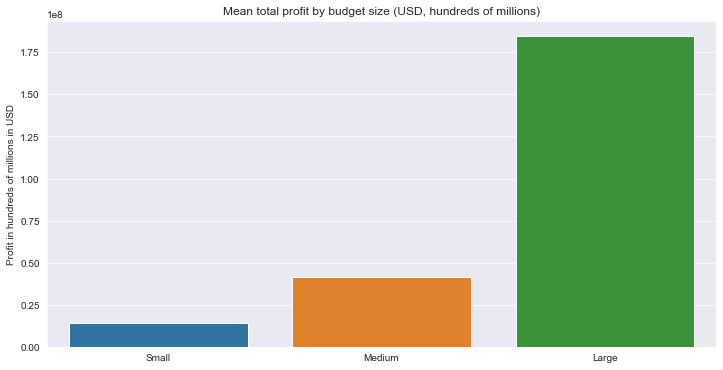

In [34]:
y = budgets.groupby("budget_size")["total_profit"].mean()
fig, ax = plt.subplots(figsize=(12,6))
x_values = ["Small", "Medium", "Large"]

#agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()
#ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])


sns.barplot(x=x_values, y = y, errwidth=0)
ax.set_ylabel("Profit in hundreds of millions in USD")
ax.set_title("Mean total profit by budget size (USD, hundreds of millions)")


Text(0.5, 1.0, 'Mean total domestic profit by budget size (USD, hundreds of millions)')

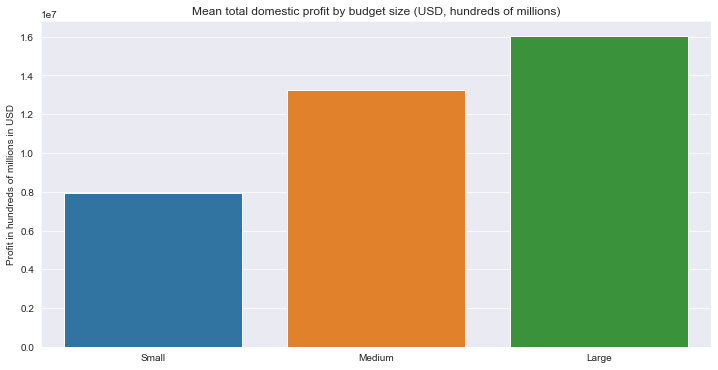

In [35]:
y = budgets_dom.groupby("budget_size")["domestic_profit"].mean()

fig, ax = plt.subplots(figsize=(12,6))
x_values = ["Small", "Medium", "Large"]

#agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()
#ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])


sns.barplot(x=x_values, y = y, errwidth=0)
ax.set_ylabel("Profit in hundreds of millions in USD")
ax.set_title("Mean total domestic profit by budget size (USD, hundreds of millions)")

Text(0.5, 1.0, 'Mean total foreign profit by budget size (USD, hundreds of millions)')

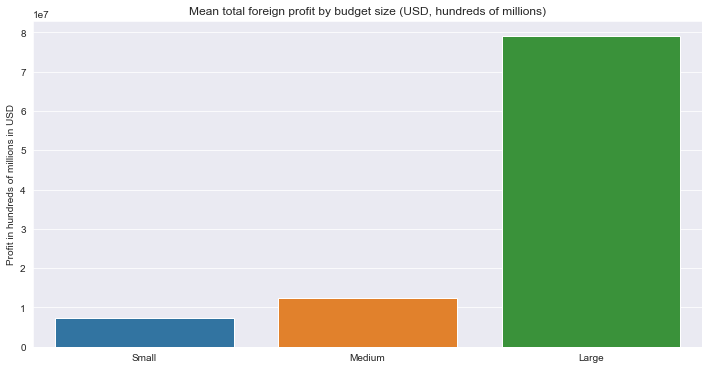

In [36]:
y = budgets_foreign.groupby("budget_size")["foreign_profit"].mean()

fig, ax = plt.subplots(figsize=(12,6))
x_values = ["Small", "Medium", "Large"]

agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()
#ax.set_yticklabels([f'{x : .2f}%' for x in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]])


sns.barplot(x=x_values, y = y, errwidth=0)
ax.set_ylabel("Profit in hundreds of millions in USD")
ax.set_title("Mean total foreign profit by budget size (USD, hundreds of millions)")

We can see in the above visualization that the large budget movies tend to perform way better internationally as the foreign audiences may be specially catered to through targeted marketing, dubbing, etc.

Text(0.5, 1.0, 'Average gross margin per budget size')

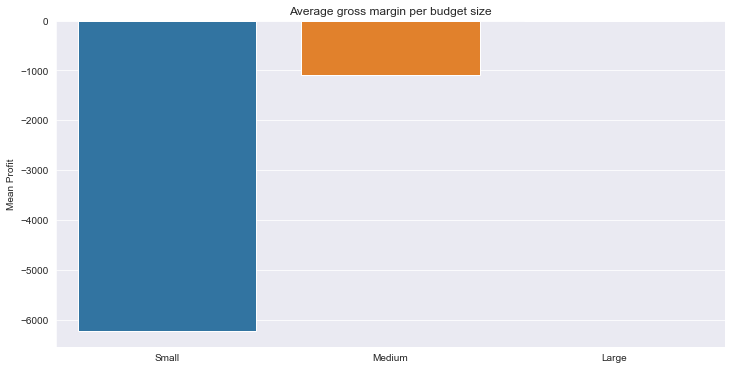

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ["Small", "Medium", "Large"]

agg_profit = budgets.groupby('budget_size')['gross_margin_ww'].mean()



sns.barplot(x=x_values, y = agg_profit.values, errwidth=0)
ax.set_ylabel("Mean Profit")
ax.set_title("Average gross margin per budget size")

Overall, we see that the different budget sizes perform in different manners that may be able to be explained through the use of the production budget for items such as marketing, etc.